In [7]:
!unzip '/content/img_align_celeba.zip'

Archive:  /content/img_align_celeba.zip
   creating: img_align_celeba/
  inflating: img_align_celeba/000001.jpg  
  inflating: img_align_celeba/000002.jpg  
  inflating: img_align_celeba/000003.jpg  
  inflating: img_align_celeba/000004.jpg  
  inflating: img_align_celeba/000005.jpg  
  inflating: img_align_celeba/000006.jpg  
  inflating: img_align_celeba/000007.jpg  
  inflating: img_align_celeba/000008.jpg  
  inflating: img_align_celeba/000009.jpg  
  inflating: img_align_celeba/000010.jpg  
  inflating: img_align_celeba/000011.jpg  
  inflating: img_align_celeba/000012.jpg  
  inflating: img_align_celeba/000013.jpg  
  inflating: img_align_celeba/000014.jpg  
  inflating: img_align_celeba/000015.jpg  
  inflating: img_align_celeba/000016.jpg  
  inflating: img_align_celeba/000017.jpg  
  inflating: img_align_celeba/000018.jpg  
  inflating: img_align_celeba/000019.jpg  
  inflating: img_align_celeba/000020.jpg  
  inflating: img_align_celeba/000021.jpg  
  inflating: img_align_cel

In [8]:
import time
import os
import numpy as np
import torch
import random
from platform import python_version

import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as vutils

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [9]:
#Matplot device setting
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
CUDA = 'cuda:0'
DEVICE = torch.device(CUDA if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 62
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002
NUM_EPOCHS = 7
BATCH_SIZE = 128
NUM_WORKERS = 4
IMAGE_SIZE = (64, 64, 3)
LATENT_DIM = 100
NUM_MAPS_GEN = 64
NUM_MAPS_DIS = 64
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

(218, 178, 3)


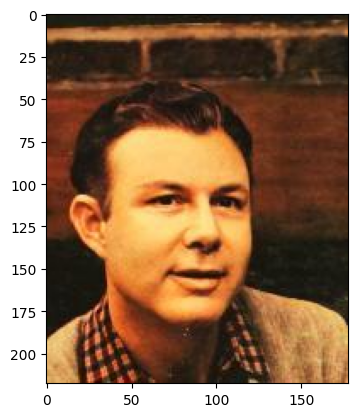

In [46]:
img = Image.open(os.path.join('/content/img_align_celeba/001767.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [47]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, img_dir, transform=None):

        self.img_dir = img_dir

        self.img_names = [i for i in
                          os.listdir(img_dir)
                          if i.endswith('.jpg')]

        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.img_names)

In [48]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid': transforms.Compose([
        transforms.Resize([IMAGE_SIZE[0], IMAGE_SIZE[1]]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}
train_dataset = CelebaDataset(img_dir=os.path.join('/content/img_align_celeba'),
                                transform=data_transforms['train'])
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          num_workers=2,
                          shuffle=True)
train_loader

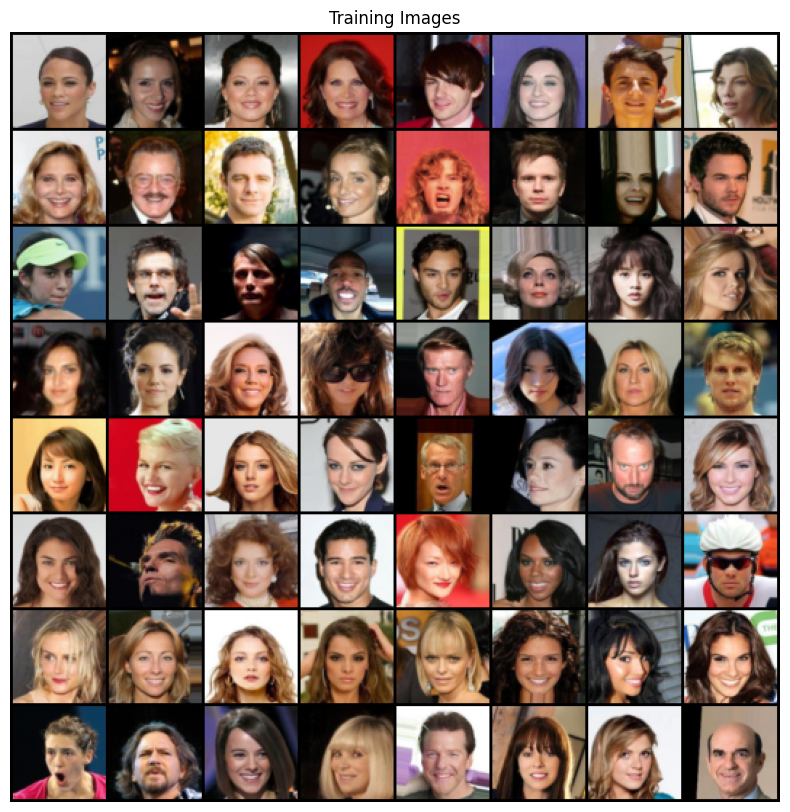

In [49]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True),(1, 2, 0)))

In [50]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [51]:
##Create DEEP CONVOLUTİONAL GAN class oluşturulması
class DCGAN(torch.nn.Module):

    def __init__(self):
        super(DCGAN, self).__init__()


        self.generator = nn.Sequential( #Generator için Torch oluşturulması
            #
            # input size: vector z of size LATENT_DIM
            #
            nn.ConvTranspose2d(LATENT_DIM, NUM_MAPS_GEN*8,    # görüntüye Gürültü eklemesi
                               kernel_size=4, stride=1, padding=0,
                               bias=False), # bias is redundant when using BatchNorm
            nn.BatchNorm2d(NUM_MAPS_GEN*8),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*8 x 4 x 4
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*8, NUM_MAPS_GEN*4,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN*4),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*4 x 8 x 8
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*4, NUM_MAPS_GEN*2,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN*2),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*2 x 16 x 16
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*2, NUM_MAPS_GEN,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN x 32 x 32
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN, IMAGE_SIZE[2],
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: IMAGE_SIZE[2] x 64 x 64
            #
            nn.Tanh()
        )

        self.discriminator = nn.Sequential( #Discrimintor için Torch oluşturulması
            #
            # input size IMAGE_SIZE[2] x IMAGE_SIZE[0] x IMAGE_SIZE[1]
            #
            nn.Conv2d(IMAGE_SIZE[2], NUM_MAPS_DIS,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS x 32 x 32
            #
            nn.Conv2d(NUM_MAPS_DIS, NUM_MAPS_DIS*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(NUM_MAPS_DIS*2),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*2 x 16 x 16
            #
            nn.Conv2d(NUM_MAPS_DIS*2, NUM_MAPS_DIS*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(NUM_MAPS_DIS*4),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*4 x 8 x 8
            #
            nn.Conv2d(NUM_MAPS_DIS*4, NUM_MAPS_DIS*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(NUM_MAPS_DIS*8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*8 x 4 x 4
            #
            nn.Conv2d(NUM_MAPS_DIS*8, 1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )


    def generator_forward(self, z):  #Generator geri beslme fonksiyonu
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):  #discriminator Geri besleme fonksiyonu
        pred = model.discriminator(img)
        return pred

In [52]:
torch.manual_seed(RANDOM_SEED)
loss_function = nn.BCELoss().float()
real_label = 1
fake_label = 0
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=DEVICE)
model = DCGAN()
model = model.to(DEVICE)
model.apply(weights_init)

print(model)

DCGAN(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
 

In [39]:
optim_gener = torch.optim.Adam(model.generator.parameters(),
                               betas=(0.5, 0.999),
                               lr=GENERATOR_LEARNING_RATE)
optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [53]:
#Eğitim başlasın
start_time = time.time()

discr_costs = []
gener_costs = []
images_from_noise = []


for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, features in enumerate(train_loader):



        #  Discriminator eğitimi


        optim_discr.zero_grad()

        real_images = features.to(DEVICE)
        num_real = real_images.size(0)
        real_label_vec = torch.full((num_real,), real_label, device=DEVICE).float()


        # Discirimatordeki gercek ve fake resimlerin alınması
        discr_pred_real = model.discriminator_forward(real_images).view(-1).float()
        real_loss = loss_function(discr_pred_real, real_label_vec)
        #real_loss.backward()

        # Discirimatordeki fake ve kayıp resim bilgilerin alınması
        random_vec = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=DEVICE).float()
        fake_images = model.generator_forward(random_vec)
        fake_label_vec = torch.full((num_real,), fake_label, device=DEVICE).float()
        discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss = loss_function(discr_pred_fake, fake_label_vec)
        #fake_loss.backward()

        # gercek ve real resim kayıp bilgisi
        discr_loss = 0.5*(real_loss + fake_loss)
        discr_loss.backward()

        optim_discr.step()

        #Genarator Eğitimi

        optim_gener.zero_grad()

        discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_function(discr_pred_fake, real_label_vec)
        gener_loss.backward()

        optim_gener.step()


        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())


        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), gener_loss, discr_loss))

    ### Üretilen imajların kayıt edilmesi
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        images_from_noise.append(
            vutils.make_grid(fake_images, padding=2, normalize=True))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/007 | Batch 000/015 | Gen/Dis Loss: 0.5149/0.9949
Time elapsed: 2.18 min
Epoch: 002/007 | Batch 000/015 | Gen/Dis Loss: 0.5609/0.9745
Time elapsed: 4.33 min
Epoch: 003/007 | Batch 000/015 | Gen/Dis Loss: 0.5632/0.9372
Time elapsed: 6.49 min
Epoch: 004/007 | Batch 000/015 | Gen/Dis Loss: 0.5362/0.9586
Time elapsed: 8.62 min
Epoch: 005/007 | Batch 000/015 | Gen/Dis Loss: 0.6494/0.8914
Time elapsed: 10.79 min
Epoch: 006/007 | Batch 000/015 | Gen/Dis Loss: 0.5319/1.0389
Time elapsed: 12.92 min
Epoch: 007/007 | Batch 000/015 | Gen/Dis Loss: 0.5933/0.9271
Time elapsed: 15.05 min
Total Training Time: 15.05 min


<ipython-input-54-ce6871850e9a>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(newlabel[::10])


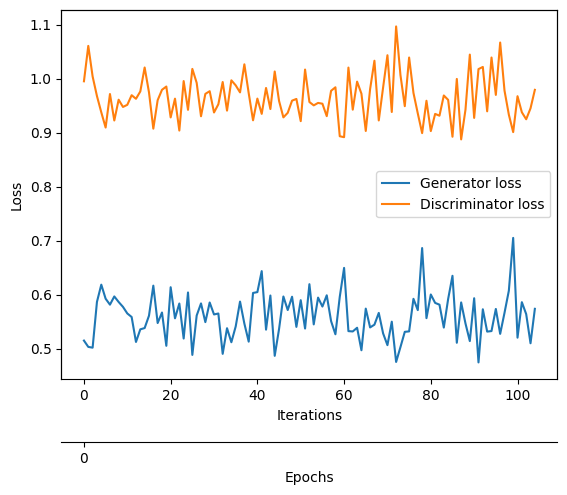

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

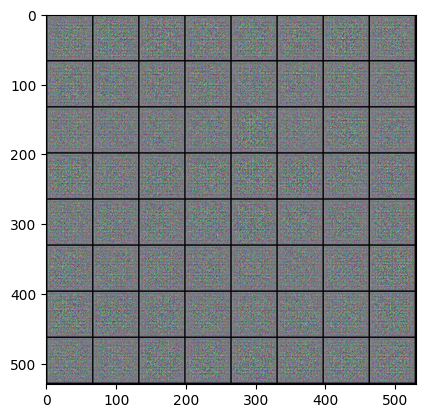

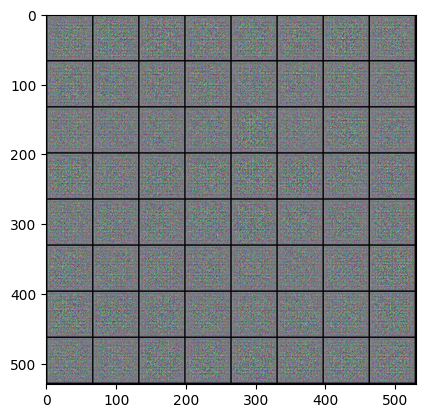

In [55]:
for i in range(0, NUM_EPOCHS, 5):
    plt.imshow(np.transpose(images_from_noise[i], (1, 2, 0)))
    plt.show()

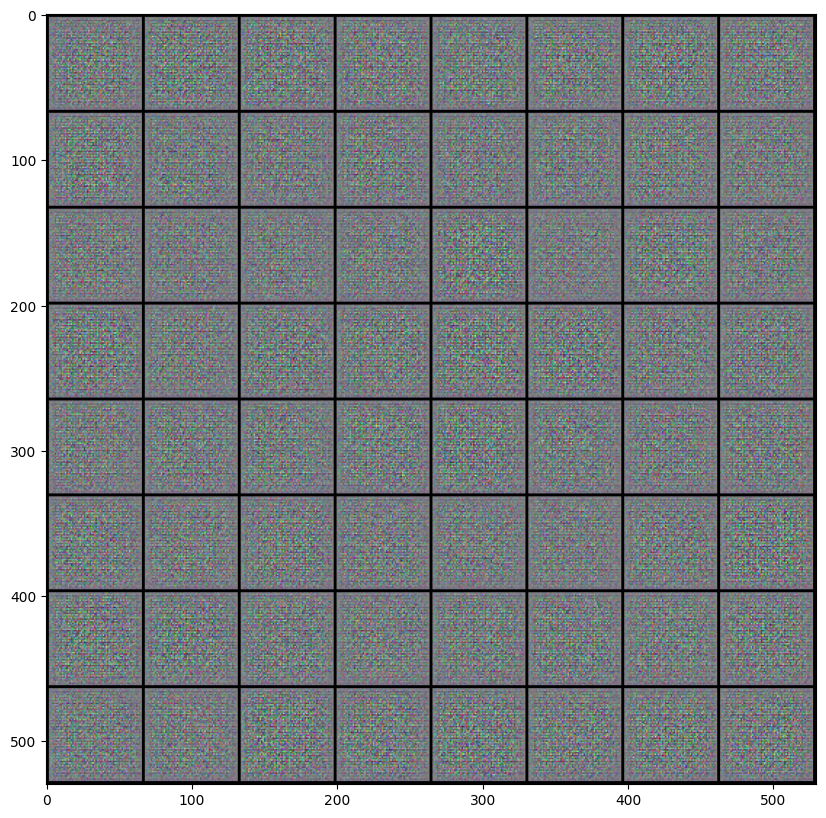

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(images_from_noise[-1], (1, 2, 0)))
plt.show()